# Tabelle in der Wald Broschüre 

**Katharina Bülow**, Climate Service Center Germany (GERICS), Helmholtz-Zentrum hereon GmbH, Email: katharina.buelow@hereon.de

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colormaps
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

To create the table, you have to read two dataframes, one with the values and on with robustness

In [3]:
# organising some directories and output files

workdir = os.getcwd()

plotdir = "plots_of_table"
outdir = os.path.join(workdir, plotdir)
if not os.path.exists(outdir):
    os.makedirs(outdir)

datadir=workdir.split('Notebooks')[0]
# CORDEX
cordex = "input_data/cordex"
indir = os.path.join(datadir, cordex)
# EOBS
obs = "input_data/eobs"
indirObs = os.path.join(datadir, obs)
indirObs

'/work/ch0636/g300047/GITHUB/climate-action-sheet-forestry/input_data/eobs'

In [4]:
# Es wird nur RCP8.5 verwendet

# Region you like to select:
region = "08212_08215_07334_Region_um_Karlsruhe"
ort = "Karlsruhe"

# Absolute change or pro
# method='pro'
method = "absolute"

# You can use min/max or percentile as well as  mean/media

# This is not nice, could get changed
if method == "pro":
    fix = "rcp85_time-mean_ensemble-diff-frac-median"
    fixm = "rcp85_time-mean_ensemble-diff-frac-min-max"
    fixr = "rcp85_ensemble-robustness"
else:
    fix = "rcp85_time-mean_ensemble-diff-median"
    fixm = "rcp85_time-mean_ensemble-diff-min-max"
    fixr = "rcp85_ensemble-robustness"

frequency = "year"
index_season = ["TG", "RRm", "DD", "FG"]

# Farben für die Robustheit festlegen:
# grau:
cmap_dict = {0: "#f7f7f7", 1: "#cccccc", 2: "#969696", 3: "#636363"}

# Indices: Frost, Late Frost, Precipitation, Wind, Heat, Heatwave and Drought
index = [
    "FD",
    "LFD",
    "RRm",
    "SU30",
    "SU35",
    "HSx3",
    "HSf3",
    "DD",
    "DSx5",
    "DSf",
]

plotname = "Karlsruhe_table_GWL_" + region + "_median_grey_300.png"
figure = os.path.join(outdir, plotname)

In [5]:
def rename(df, ind, frequency, fix, fixm, fixr):
    # Rename columns of DataFrame
    # with the name you eventually like to see in the table

    df_ = df.copy()
    return df_.rename(
        columns={
            "ci_name": "Index",
            ind + "_" + frequency + "_ref_time-mean": "1971-2000",
            "dummy": "1971-2000",
            ind + "_" + frequency + "_1.5C_" + fix: "Änderung 1.5 °C",
            ind + "_" + frequency + "_2C_" + fix: "Änderung 2 °C",
            ind + "_" + frequency + "_3C_" + fix: "Änderung 3 °C",
            ind + "_" + frequency + "_4C_" + fix: "Änderung 4 °C",
            ind + "_" + frequency + "_1.5C_" + fixr: "Änderung 1.5 °C",
            ind + "_" + frequency + "_2C_" + fixr: "Änderung 2 °C",
            ind + "_" + frequency + "_3C_" + fixr: "Änderung 3 °C",
            ind + "_" + frequency + "_4C_" + fixr: "Änderung 4 °C",
            ind + "_" + frequency + "_1.5C_" + fixm: "Änderung 1.5 °C",
            ind + "_" + frequency + "_2C_" + fixm: "Änderung 2 °C",
            ind + "_" + frequency + "_3C_" + fixm: "Änderung 3 °C",
            ind + "_" + frequency + "_4C_" + fixm: "Änderung 4 °C",
        }
    )

In [6]:
def rename_index(df):
    # Rename Index in 1. column of the table
    df_ = df.copy()
    return df_.rename(
        index={
            "TG": "Temperatur [°C]",
            "TG1": "Winter [°C]",
            "TG4": "Frühjahr [°C]",
            "TG7": "Sommer [°C]",
            "TG10": "Herbst [°C]",
            "SU": "Sommertage [Tage]",
            "SU30": "Hitzetage (Tmax > 30°C) [Tage]",
            "SU35": "Temperaturmax. > 35°C [Tage]",
            "SU40": "Temperaturmax. > 40°C [Tage]",
            "FD": "Frosttage [Tage]",
            "LFD": "Spätfrosttage [Tage]",
            "HSx3": "max. Hitzewelle [Tage]",
            "HSf3": "Hitzewellen [Anzahl]",
            "RRm": "jährl. Niederschlag [mm/Tag]",
            "RRm1": "Winterniederschlag [mm/Tag]",
            "RRm4": "Frühlingsniederschlag [mm/Tag]",
            "RRm7": "Sommerniederschlag [mm/Tag]",
            "RRm10": "Herbstniederschlag [mm/Tag]",
            "DD1": "Trockentage im Winter [Tage]",
            "DD4": "Trockentage im Frühjahr [Tage]",
            "DD7": "Trockentage im Sommer [Tage]",
            "DD10": "Trockentage im Herbst [Tage]",
            "DD": "Trockentage im Jahr [Tage]",
            "DSx5": "jährl. max.Trockenperiode [Tage]",
            "DSf": "jährl. Trockenperioden [Anzahl]",
            "FG": "Windgeschwindigkeit [m/s]",
            "FG1": "Winter [m/s]",
            "FG4": "Frühjahr [m/s]",
            "FG7": "Sommer [m/s]",
            "FG10": "Herbst [m/s]",
        }
    )

In [7]:
def minmax(files, region, s, method):
    # read minimum and maximum files and
    # squeeze them in one column to fit into the table below the mean

    # observations do not have Min Max jet, only one Data file available till now
    dft = pd.DataFrame(["Min:Max"], columns=["ci_name"])
    dfd = pd.DataFrame(np.nan, index=[0], columns=["dummy"])
    dft = pd.concat([dft, dfd], axis=1)

    for i in files:
        if method == "pro":
            minfile = i.replace("diff-frac-median", "diff-frac-min")
            maxfile = i.replace("diff-frac-median", "diff-frac-max")
        else:
            minfile = i.replace("diff-median", "diff-min")
            maxfile = i.replace("diff-median", "diff-max")

        dfmin = pd.read_csv(minfile)
        dfmax = pd.read_csv(maxfile)

        seln_ = select_region(dfmin, region)
        selx_ = select_region(dfmax, region)
        seln = seln_.loc[(seln_["mid_month"].isin([s]))]
        selx = selx_.loc[(selx_["mid_month"].isin([s]))]

        cmin = col_name(minfile)
        cmax = col_name(maxfile)

        if method == "pro":
            endcmax = cmax.split("-")[4]
            t = seln[cmin]
            val_cmin = t * 100
            tm = selx[cmax]
            val_cmax = tm * 100
            dfn = val_cmin.map("{:,.1f}".format)
            dfm = val_cmax.map("{:,.1f}".format)
        else:
            endcmax = cmax.split("-")[3]
            dfn = seln[cmin].map("{:,.1f}".format)
            dfm = selx[cmax].map("{:,.1f}".format)

        dfn_ = dfn.reset_index(drop=True)
        dfm_ = dfm.reset_index(drop=True)
        dft_ = pd.concat([dft, dfn_, dfm_], axis=1)
        dft__ = dft_.replace("0.0", "0")
        dft = dft__.replace("-0.0", "0")
        dft[cmin + "-" + endcmax] = dft[cmin] + " : " + dft[cmax]
        dft.drop([cmin, cmax], inplace=True, axis=1)

    return dft

In [8]:
def select_region(df, region):
    return df.loc[(df["region"].isin([region]))]

In [16]:
def col_name(i):
    # get name of the column
    t = i.split("/")[-1]
    c = t.split(".cs")[0]
    return c

In [17]:
def col_eobs_name(i):
    # get name of the column
    t = i.split("/")[-1]
    c = t.split(".cs")[0]
    return c

In [18]:
def read_eobs(i, ind, frequency, saison):
    """read seasonal refence value for today 1971-2000"""

    dft = pd.DataFrame()
    df = pd.read_csv(i)
    sel = select_region(df, region)
    c = col_eobs_name(i)
    if ind == "TG":
        sel[c] = sel[c] - 273.15

    if saison == 12:
        dft["Index"] = sel["ci_name"]
        dfl = sel[c].map("{:,.1f}".format)

    else:
        sel_ = sel.loc[(sel["mid_month"].isin([saison]))]
        dfl = sel_[c].map("{:,.1f}".format)
        dft["Index"] = sel_["ci_name"].str.cat(sel_["mid_month"].values.astype(str))

    dft = pd.concat([dft, dfl], axis=1)
    return dft

In [19]:
def gwl(files, region, dft, s):
    # You have to name the columns, otherwise there could be a mistake:
    for gwl in ("_1.5C_", "_2C_", "_3C_", "_4C_"):
        dfile = sorted([dfile for dfile in files if gwl in dfile])
        i = dfile[0]
        df = pd.read_csv(i)
        sel_ = select_region(df, region)
        c = col_name(i)
        sel = sel_.loc[(sel_["mid_month"].isin([s]))]
        if "diff-frac-" in c:
            t = sel[c]
            val = t * 100
            dfl = val.map("{:,.1f} %".format)
        else:
            dfl = sel[c].map("{:,.1f}".format)
        dft.reset_index(drop=True, inplace=True)
        dfl.reset_index(drop=True, inplace=True)
        # for unclear I replace 0 with 0.5
        if "ensemble-robustness" in c:
            dfl = dfl.replace("0.0", "0.5")
        dft = pd.concat([dft, dfl], axis=1)
    return dft

In [20]:
def gwlmm(files):  # ,s)#,region,dft,s):
    # You have to name the columns, otherwise there could be a mistake:
    for gwl in ("_1.5C_", "_2C_", "_3C_", "_4C_"):
        dfile = sorted([dfile for dfile in files if gwl in dfile])
        i = dfile[0]
        c = col_name(i)

        dfmm[c] = 0
    return dfmm

In [21]:
def obs_robust(ind_, i):
    # Observations and historical have
    # has no Robust Change
    if i == 12:
        ind = ind_
    else:
        ind = ind_ + str(i)
    dft = pd.DataFrame([ind], columns=["ci_name"])
    dfd = pd.DataFrame(0, index=[0], columns=["dummy"])
    dft = pd.concat([dft, dfd], axis=1)

    # Für Robustheit bleibt Min:Max nan
    dfmm = pd.DataFrame(["Min : Max"], columns=["ci_name"])
    dfm = pd.DataFrame(np.nan, index=[0], columns=["dummy"])
    dfmm = pd.concat([dfmm, dfm], axis=1)
    return dft, dfmm

In [22]:
df_out = pd.DataFrame()

for ind in index:
    # start with annual
    # read observation as 1. column
    fileo = (
        indirObs
        + "/"
        + frequency
        + "/"
        + ind
        + "/"
        + ind
        + "_"
        + frequency
        + "_ref_time-mean.csv"
    )
    dft = read_eobs(fileo, ind, frequency, 12)
    # read euro-cordex
    files = glob(
        indir
        + "/"
        + frequency
        + "/"
        + ind
        + "/"
        + ind
        + "_"
        + frequency
        + "*"
        + fix
        + ".csv"
    )
    dfmm = minmax(files, region, 7, method)
    dfmm_ = rename(dfmm, ind, frequency, fix, fixm, fixr)
    dft = gwl(files, region, dft, 7)
    dft_ = rename(dft, ind, frequency, fix, fixm, fixr)

    # Hier wird alle unter einander geschrieben:
    df_out = pd.concat([df_out, dft_, dfmm_], axis=0)

    # season:
    if ind in index_season:
        fileo = (
            indirObs
            + "/"
            + "sem"
            + "/"
            + ind
            + "/"
            + ind
            + "_"
            + "sem"
            + "_ref_time-mean.csv"
        )
        for i in [4, 7]:
            dft = read_eobs(fileo, ind, frequency, i)
            files = glob(
                indir + "/sem/" + ind + "/" + ind + "_sem_" + "*" + fix + ".csv"
            )
            dfmm = minmax(files, region, i, method)
            dfmm_ = rename(dfmm, ind, "sem", fix, fixm, fixr)
            dft = gwl(files, region, dft, i)
            dft_ = rename(dft, ind, "sem", fix, fixm, fixr)
            # Here everything is written below each other
            df_out = pd.concat([df_out, dft_, dfmm_], axis=0)

# set index
df_out_ = df_out.copy()
df_index_ = df_out_.set_index(["Index"])
df_index__ = df_index_.replace("-0.0", "0")
df_index = df_index__.replace("0.0", "0")

Now we need exactly the same dataframe to display the robustness in color. Min:Max have no robustness, it is highlighted in light gray. MinMax has not yet been calculated for Obs: empty & white, so the robustness must be set to nan here.

In [23]:
df_r = pd.DataFrame()

for ind in index:
    # observation hat keine Robustheit
    dft, dfmm = obs_robust(ind, 12)
    # euro-cordex:
    files = glob(
        indir
        + "/"
        + frequency
        + "/"
        + ind
        + "/"
        + ind
        + "_"
        + frequency
        + "*"
        + fixr
        + ".csv"
    )
    dft = gwl(files, region, dft, 7)
    dfmm = gwlmm(files)

    dft_ = rename(dft, ind, frequency, fix, fixm, fixr)
    dfmm_ = rename(dfmm, ind, frequency, fix, fixm, fixr)

    # here everything will be written below each other
    df_r = pd.concat([df_r, dft_, dfmm_], axis=0)
    # season
    if ind in index_season:
        for i in [4, 7]:
            dft, dfmm = obs_robust(ind, i)
            files = glob(
                indir + "/sem/" + ind + "/" + ind + "_sem_" + "*" + fixr + ".csv"
            )
            dft = gwl(files, region, dft, i)
            dfmm = gwlmm(files)
            dfmm_ = rename(dfmm, ind, "sem", fix, fixm, fixr)
            dft_ = rename(dft, ind, "sem", fix, fixm, fixr)
            # Here we write everything below each other:
            df_r = pd.concat([df_r, dft_, dfmm_], axis=0)

# set index
dfr = df_r.copy()
df_rob = dfr.set_index(["Index"])
df_rob

,1971-2000,Änderung 1.5 °C,Änderung 2 °C,Änderung 3 °C,Änderung 4 °C
Index,,,,,
FD,0.0,-2.0,-2.0,-2.0,-2.0
Min : Max,NaN,0,0,0,0
LFD,0.0,-2.0,-2.0,-2.0,-2.0
Min : Max,NaN,0,0,0,0
RRm,0.0,1.0,1.0,1.0,1.0
Min : Max,NaN,0,0,0,0
RRm4,0.0,1.0,1.0,1.0,1.0
Min : Max,NaN,0,0,0,0
RRm7,0.0,nan,nan,nan,-1.0


#### Bedeutung der Zahlen für die Robustheit:

* Threshold für Änderung=2/3
* Threshold für Signifikanz=0.5

**2** robust 2/3 in eine Richtung und 0.5 Signifikant

**1** trend 2/3 in einen Richtung

**0** unklar +/- aber 0.5 sind significant

**NaN** no change weniger als 2/3 und weniger als 1/2 signifikant

- file change_frac steht die Significanz
- file pos_frac significant und positiv
- file diff_pos_frac positive


In [24]:
# 0 is needed later for nan,
# eobs and min max have no robustness, are therefore set to NaN
# if NaN is in heatmap, the value is also missing, intentionally for obs
# therefore the nan is replaced with 0
# nan was read in
df_robn_ = df_rob.replace("nan", 0)

## jetzt plotten:


In [25]:
# The robustness parameters are overwritten once,
# because working with the colorbar is easier with uniform spacing
# No scientific reason just to simplify the color design
# NaN in white

df_rob_ = df_robn_.replace(
    {
        "-2.0": "3",
        "-1.0": "2",
        "-0.5": "1",
        0: "0",
        "0.0": "0",
        "0.5": "1",
        "1.0": "2",
        "2.0": "3",
    }
)

for i in df_rob_.columns:
    df_rob_[i] = df_rob_[i].astype(float)

In [26]:
df_rob_ = rename_index(df_rob_)
# df_rob_

In [27]:
df_index = rename_index(df_index)

In [28]:
# Make Table clearer:
def add_plus(value):
    float_value = float(value)
    if float_value > 0:
        return "+" + str(float_value)
    else:
        return value

In [29]:
# a collection for the plot


# Define custom annotation font sizes based on index string
def annotate_row(row_index):
    if row_index == "Min:Max":
        return [8, 8, 8, 8, 8]  # Font sizes for each column in row
    else:
        return [12, 12, 12, 12, 12]  # Default font sizes


def annotate_row_weight(row_index):
    if row_index == "Min:Max":
        return ["light", "light", "light", "light", "light"]
    else:
        return [
            "bold",
            "bold",
            "bold",
            "bold",
            "bold",
        ]  # Font weight for each column in row


def label_color(label):
    if label == "Hitzetage (Tmax > 30°C) [Tage]":
        return "#dcab4c"
    if label == "Temperaturmax. > 35°C [Tage]":
        return "#dcab4c"
    if label == "max. Hitzewelle [Tage]":
        return "#cf6752"
    if label == "Hitzewellen [Anzahl]":
        return "#cf6752"
    if label == "Frosttage [Tage]":
        return "#97b0ca"
    if label == "Spätfrosttage [Tage]":
        return "#97b0ca"
    if label == "jährl. Niederschlag [mm/Tag]":
        return "#615793"
    if label == "Frühlingsniederschlag [mm/Tag]":
        return "#615793"
    if label == "Sommerniederschlag [mm/Tag]":
        return "#615793"
    if label == "Trockentage im Jahr [Tage]":
        return "#882a4f"
    if label == "Trockentage im Frühjahr [Tage]":
        return "#882a4f"
    if label == "Trockentage im Sommer [Tage]":
        return "#882a4f"
    if label == "jährl. max.Trockenperiode [Tage]":
        return "#882a4f"
    if label == "jährl. Trockenperioden [Anzahl]":
        return "#882a4f"
    else:
        return "k"

Plot saved:  /work/ch0636/g300047/GITHUB/climate-action-sheet-forestry/Notebooks/INDICES-TABLE/plots_of_table/Karlsruhe_table_GWL_08212_08215_07334_Region_um_Karlsruhe_median_grey_300.png


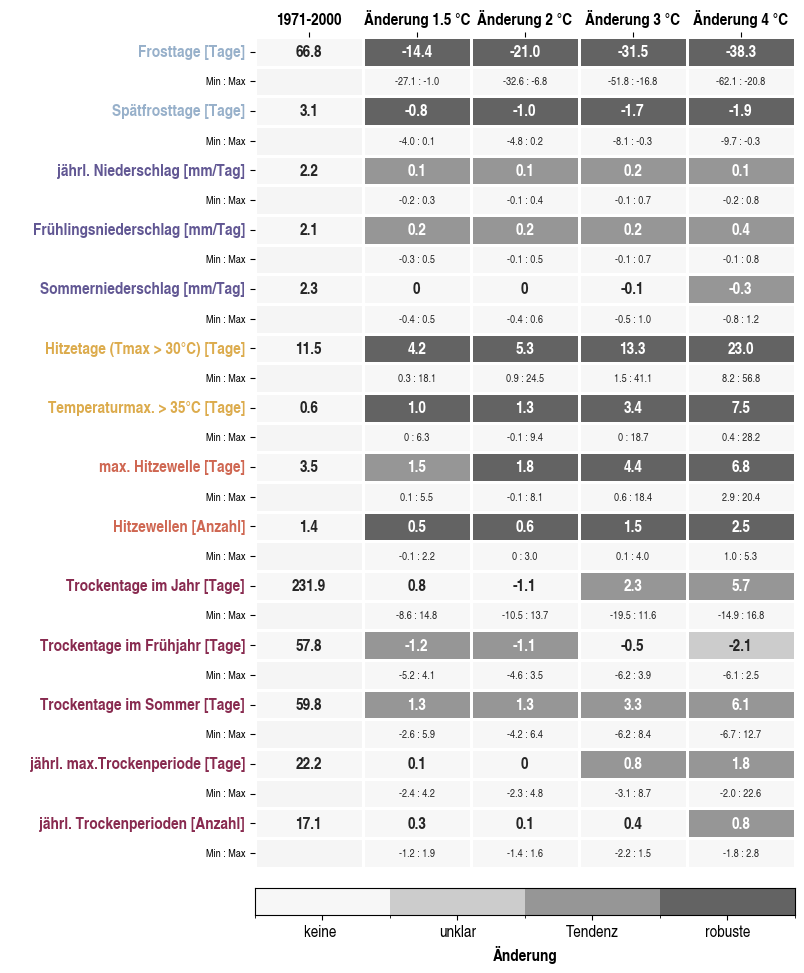

In [30]:
# plotting:
# strangely I have to run this box twice to change to text style
plt.rcParams["font.family"] = "Nimbus Sans Narrow"

colorrange = range(len(list(cmap_dict.keys())))
cmap = ListedColormap([cmap_dict[i] for i in [0, 1, 2, 3]])
bounds = np.array(range(len(list(cmap_dict.keys())) + 1)) - 0.5

# this is needed to have exactly one color box per number

norm = mpl.colors.BoundaryNorm(bounds, len(colorrange))

# annot ist df_ der Wert des Indices, die farbe ist die robustheit dfr_
size = (8, 13)
fig, ax = plt.subplots(figsize=size)
# plt.rcParams['font.family'] = 'Nimbus Sans Narrow'
fig.subplots_adjust(right=0.8)

ax = sns.heatmap(
    df_rob_,
    annot=df_index,
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar_kws={
        "orientation": "horizontal",
        "pad": 0.02,
        "label": "Änderung",
    },
    linewidths=1,
)
ax.set_facecolor("whitesmoke")
ax.figure.axes[-1].xaxis.label.set_size(12)  # größe der Schrift der colorbar legende
ax.figure.axes[-1].xaxis.label.set_fontweight("bold")


for label in ax.get_yticklabels():
    lc = label_color(label.get_text())
    label.set_color(lc)
    if label.get_text() != "Min : Max":
        label.set_weight("bold")
        label.set_size(12)
    else:
        label.set_size(8)


# This is a terrible work around, since 'min-Max have an NaN in the first column and I could not get rid of it
m = 0
for i in range(len(df_index)):
    font_sizes = annotate_row(df_index.index[i])
    font_weight = annotate_row_weight(df_index.index[i])

    if i % 2 == 1:
        end = 4
    else:
        end = 5
        for k in range(1, end):
            df_index.iat[i, k] = add_plus(df_index.iat[i, k])

    for j in range(end):
        ax.texts[m].set_fontsize(font_sizes[j])
        ax.texts[m].set_fontweight(font_weight[j])
        # This would be nice, but does not work with naN
        # ax.texts[i * len(df_index.columns) + j].set_fontsize(font_sizes[j])
        m = m + 1

# Colorbar manipulieren:
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])

# Hier nochmal gucken was man hinneinschreiben möchte
c_bar.set_ticklabels(
    ["keine ", "unklar", "Tendenz", "robuste"],
    fontsize=12,
)
ax.xaxis.tick_top()  # x axis on top
ax.xaxis.set_label_position("top")
ax.set_ylabel(" ")
# ax.set_title(ort, color="k", fontsize=18)
plt.yticks(rotation=0)  # , fontsize=12)
plt.xticks(rotation=0, fontsize=12, fontweight="bold")

# spine draws the box around the colorbar
for spine in ax.collections[0].colorbar.ax.spines.values():
    spine.set_visible(True)  # show the border of the colorbar

# save plot:
plt.savefig(figure, dpi=300, bbox_inches="tight")
print("Plot saved: ", figure)